Ya he conseguido entrenar el modelo etc. Ahora vamos a entrenarlo con datos que tengan 1 anomaĺia. Una sinusoide que tenga un pico.


In [1]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

# Los datos sinteticos CON ANOMALÍAS

Voy a hacer un generador que nos de una secuencia regular, con puntos de anomalia


In [2]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)


In [3]:
def add_global_anom(x,anoms=1):
    x=x.to(float)
    #añade en una disposiciónaleatoria, un pico del orden de las obervaciones
    magnitud=x.max().item()-x.min().item()
    index=torch.from_numpy(np.random.choice(np.arange(0,x.size()[0]),size=anoms,replace=False))
    x[index]= torch.from_numpy(magnitud*np.random.randn(anoms))
    return x
    

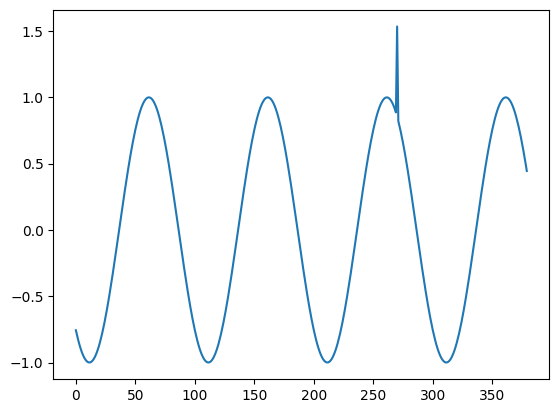

In [4]:
y=add_global_anom(sinne(380,sf=0.1,f=1,phase=4))
plt.plot(y)

Y ahora el generador de datos. Le decimos que nos devuelva un batch de datos y nos lo da.

In [5]:
class DataWithAnom(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,lenght,num_samples,amp_random=True,freq_random=True,phase_random=True,sf=0.1):
        super().__init__()
        self.amp_random=amp_random
        self.freq_random=freq_random
        self.phase_random=phase_random
        self.num_samples=num_samples
        self.sf=0.1
        self.lenght=lenght

    def __len__(self):

        return self.num_samples


    def __getitem__(self, index):
        amp=float(np.random.randint(1,300,1)*0.01)
        phase=np.random.randint(0,100,1)*0.02
        f=np.random.randint(1,200,1)*0.01
        y=add_global_anom(sinne(lenght=self.lenght,amp=amp,sf=0.1,f=f,phase=phase))
        y=y.unsqueeze(-1)
        return y


In [6]:
win_size=600
data=DataWithAnom(win_size,4000)

dataloader=DataLoader(data,batch_size=32,shuffle=True)

In [7]:
def warmup_and_decay_learning_rate(optimizer, epoch, init_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        lr = init_lr * (epoch / warmup_epochs)
        print('Warmup: Updating learning rate to {}'.format(lr))
    else:
        decay_epochs = total_epochs - warmup_epochs
        decay_rate = 1e-7+(epoch - warmup_epochs) / decay_epochs
        lr = init_lr * (1 - decay_rate)
        print('Decay: Updating learning rate to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr




def count_parameters(model):
    
    total=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total}")
    return total
#count_parameters(modelo)

## Entrenamiento
Añadimos en el entrenamiendo dos fases, una de mini y otra de max

Con el output tenemos que sacar: el error de reconstrucción y el AssDiss, y luego sacar dos function loses, una donde se minimiza y otra donde de maximiza.  

El calculo de las assdis lo vamos a poner en una funcion. 

In [8]:

def clip_gradients(model, max_norm, norm_type=2):
    """
    Clip gradients of the model parameters.

    Args:
        model (torch.nn.Module): The neural network model.
        max_norm (float): The maximum allowed norm for the gradients.
        norm_type (float): The type of the norm calculation (default: 2 for L2 norm).
    """
    # Recupera todos los gradientes de los parámetros del modelo
    gradients = [param.grad for param in model.parameters() if param.grad is not None]

    # Calcula la norma total de los gradientes
    total_norm = torch.norm(torch.stack([torch.norm(grad, norm_type) for grad in gradients]), norm_type)

    # Calcula el factor de escalado para recortar los gradientes
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        # Aplica el factor de escalado a los gradientes
        for grad in gradients:
            grad.mul_(clip_coef)




# def layer_association_discrepancy( Pl, Sl):
#     #Pl y Sl viene con dimension B,Head,Height,Width
#     B,Head,Height,_ = Pl.shape
#     result=torch.zeros(B,Head,Height)
#     for batch_size in range(B):
#         for head_size in range(Head):
#             rowwise_kl = lambda row: (F.kl_div(Pl[batch_size,head_size,row, :], Sl[batch_size,head_size,row, :]) + F.kl_div(Sl[batch_size,head_size,row, :], Pl[batch_size,head_size,row, :]))
#             ad_vector = torch.concat([rowwise_kl(row).unsqueeze(0) for row in range(Height)])
#             result[batch_size,head_size,:]=ad_vector
#     return result

def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)



# def layer_association_discrepancy(Pl, Sl):
#     # Pl y Sl vienen con dimension B, Head, Height, Width
#     B, Head, Height, _ = Pl.shape

#     # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
#     kl1 = F.kl_div(Pl, Sl, reduction='none').mean(dim=-1)
#     kl2 = F.kl_div(Sl, Pl, reduction='none').mean(dim=-1)

#     # Sumar los KL Divergence calculados
#     ad_vector = kl1 + kl2

#     return ad_vector

def layer_association_discrepancy(Pl, Sl):
    # Pl y Sl vienen con dimension B, Head, Height, Width
    B, Head, Height, _ = Pl.shape

    # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
    kl1 = my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
    kl2 = my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))

    # Sumar los KL Divergence calculados
    ad_vector = kl1 + kl2

    return ad_vector



def association_discrepancy( P_list, S_list):

    return torch.stack([layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])

# (1 / len(P_list)) * sum(
#         [
#             torch.mean(layer_association_discrepancy(P, S),axis=0)#hacemos la media sobre todas las cabezas
#             for P, S in zip(P_list, S_list)
#         ]
#     )

def loss_function( x_hat, P_list, S_list, lambda_, x):
    frob_norm = ((x_hat - x)**2).mean()   #usamo MSE  #torch.linalg.matrix_norm(x_hat - x, ord="fro").mean() #norm L2 
    diss_norm=torch.mean(association_discrepancy(P_list, S_list))#torch.linalg.norm(, ord=1) # le añado esto para que se normaliza acros muestras 
    print(frob_norm,diss_norm)
    return (frob_norm.item(),diss_norm.item()),frob_norm - (lambda_* diss_norm) #hacemos la suma de todos los valores absolutos y dividimos todo por el batchsize
    

def min_loss(output,P_layers,S_layers, x,lambda_):
    P_list = P_layers
    S_list = [S.detach() for S in S_layers]
    lambda_ = -lambda_
    _,loss_value=loss_function(output, P_list, S_list, lambda_, x)
    return loss_value

def max_loss(output,P_layers,S_layers,x,lambda_):
    P_list = [P.detach() for P in P_layers]
    S_list = S_layers
    lambda_ = lambda_
    datails,loss_value=loss_function(output, P_list, S_list, lambda_, x)
    return datails,loss_value

(32, 600, 1)


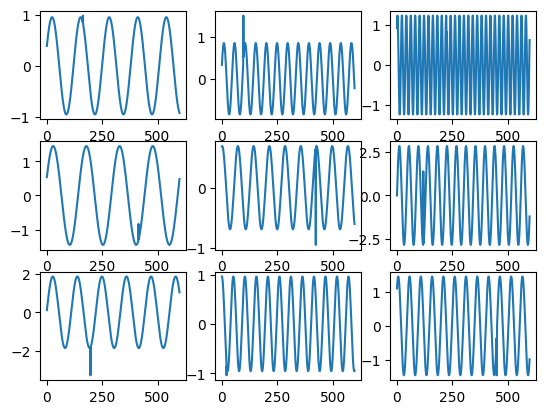

In [10]:
x_aux=next(iter(dataloader))
x_aux=x_aux.cpu().detach().numpy()
print(x_aux.shape)
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.plot(x_aux[i])

In [11]:
modelo=AnomalyTransformer.AnomalyTransformer(600, 1, 1, d_model=32, n_heads=2, e_layers=2, d_ff=32,
                          dropout=0.0, activation='gelu', output_attention=True)
modelo.cuda()


AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=2, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bi

In [12]:
#veamos a ver si hay nans en los parámetros 
a=list(modelo.parameters())
if len([i for i in a if i.isnan().sum().item()!=0])>0:
    print("HAY NANS")

In [13]:
def get_gradients(model):
    """
    Get all gradients of the model parameters.

    Args:
        model (torch.nn.Module): The neural network model.

    Returns:
        List[Tensor]: A list of gradient tensors for each model parameter.
    """
    gradients = [param.grad for param in model.parameters() if param.grad is not None]
    return gradients

gradients = get_gradients(modelo)
gradients


[]

In [14]:
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)
modelo.train()
lambda_=4.5

loss_frob_diss=[]

# Entrenamiento
num_epochs = 15
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i, (inputs) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)
        prior=[j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600) for j in prior]
        loss_min = min_loss(outputs,prior,series, inputs,lambda_)
        details,loss_max = max_loss(outputs,prior,series, inputs,lambda_)
        loss_frob_diss.append(list(details))
        # Backward y optimización
        loss_min.backward(retain_graph=True)
        loss_max.backward()
        #clip_gradients(modelo, max_norm=1)
        optimizer.step()
        optimizer.zero_grad()
        del inputs 
        torch.cuda.empty_cache()
        gc.collect()

        warmup_and_decay_learning_rate(optimizer, epoch, 1e-3,5 , num_epochs)
        # Printear resultados
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss_min: {loss_min.item():.4f}, Loss_max: {loss_max.item():.4f}")

print("Entrenamiento finalizado")

Epoch: 0
tensor(2.6684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0463, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.6684, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0463, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/15], Step [1/125], Loss_min: 43.3768, Loss_max: -38.0400
tensor(2.1087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0090, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.1087, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0090, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/15], Step [2/125], Loss_min: 42.6491, Loss_max: -38.4316
tensor(1.7251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.8622, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.8622, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/15], Step [3/125], Loss_min: 41.6050, Loss_max: -38.

In [16]:
torch.tensor([1]).item()

1

In [16]:
#modelo.cuda()
a=next(iter(dataloader))
a1=a.float().to("cuda:0")
modelo.eval()
y=modelo(a1)


In [17]:
z=y[0].squeeze().cpu().detach().numpy()
series_aux=y[1][0].squeeze().cpu().detach().numpy()
prior_aux=y[2][0].squeeze().cpu().detach().numpy()
b=a1.squeeze().cpu().detach().numpy()

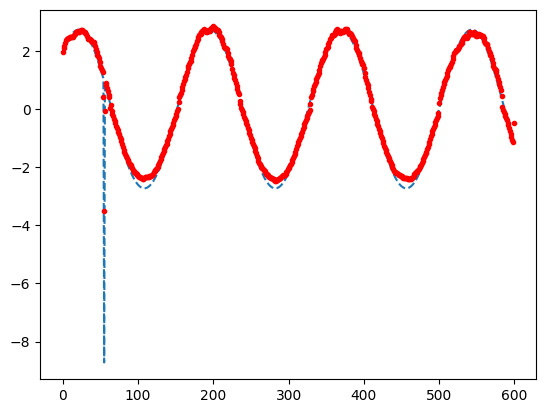

In [19]:
plt.plot(b[3],"--")
plt.plot(z[3],".r")


In [20]:
ass=association_discrepancy(y[2],y[1]).cpu().detach().numpy()
ass.shape

(32, 600)

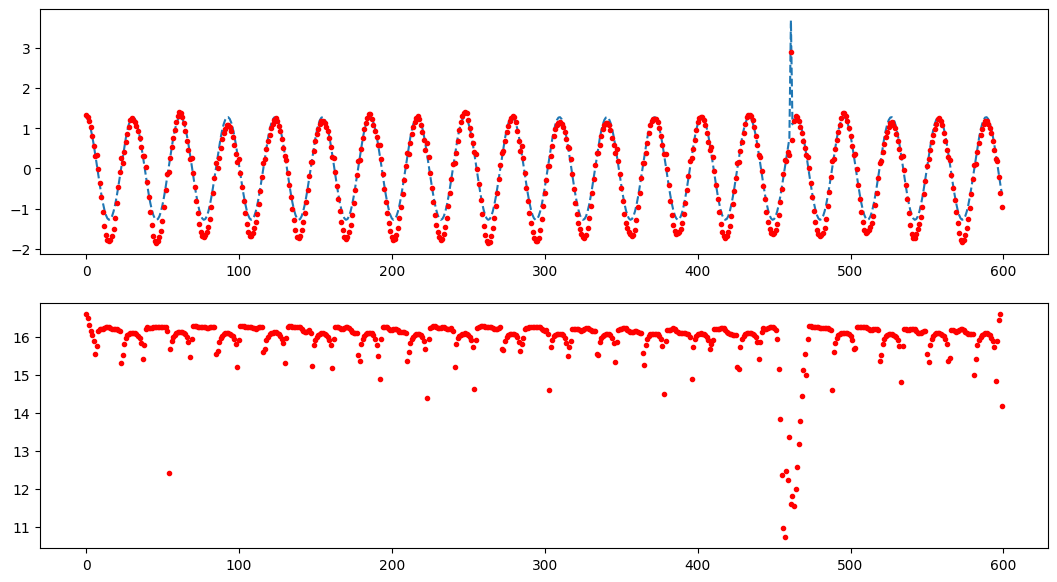

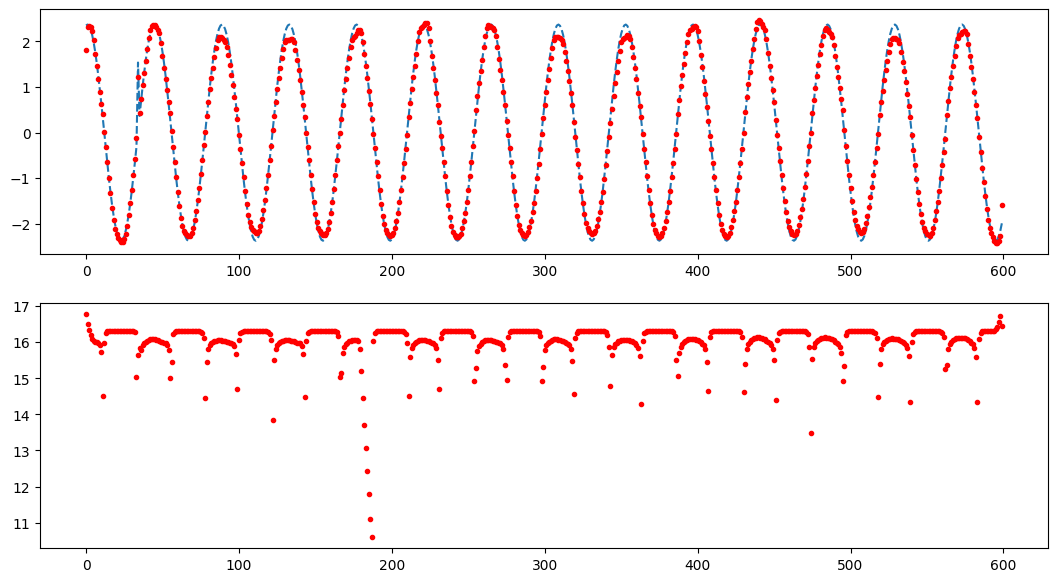

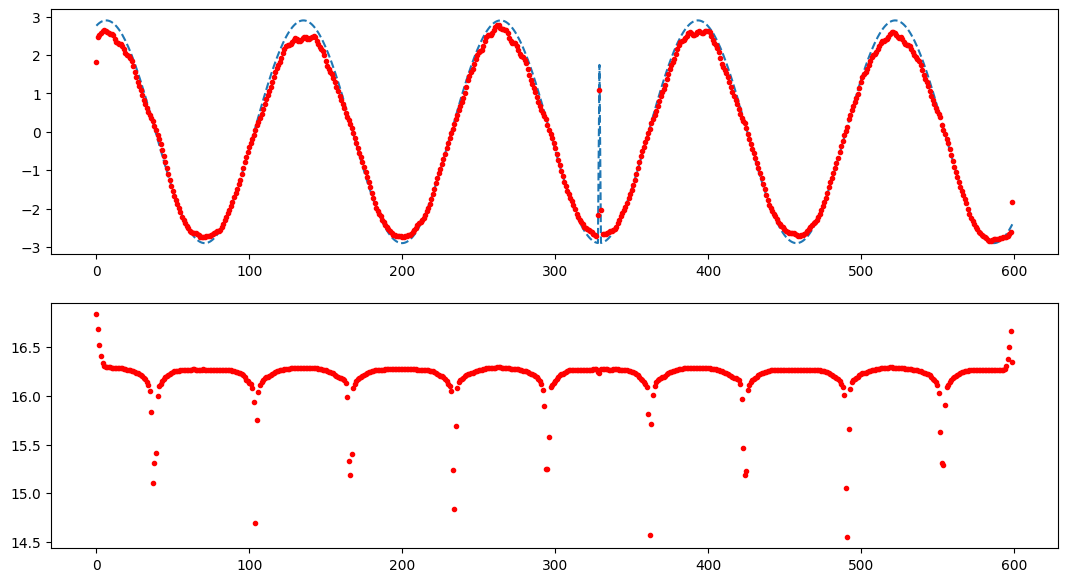

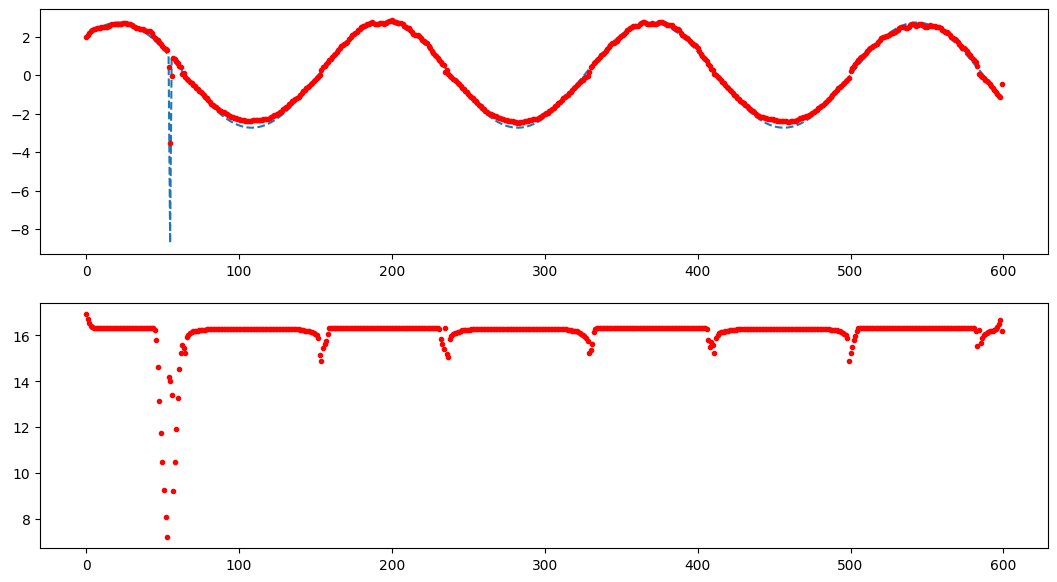

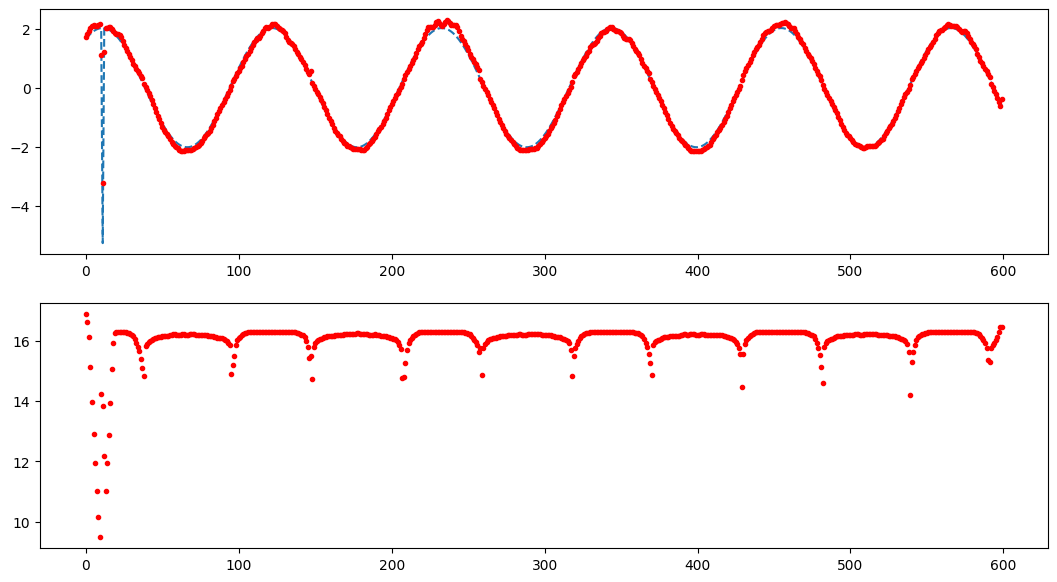

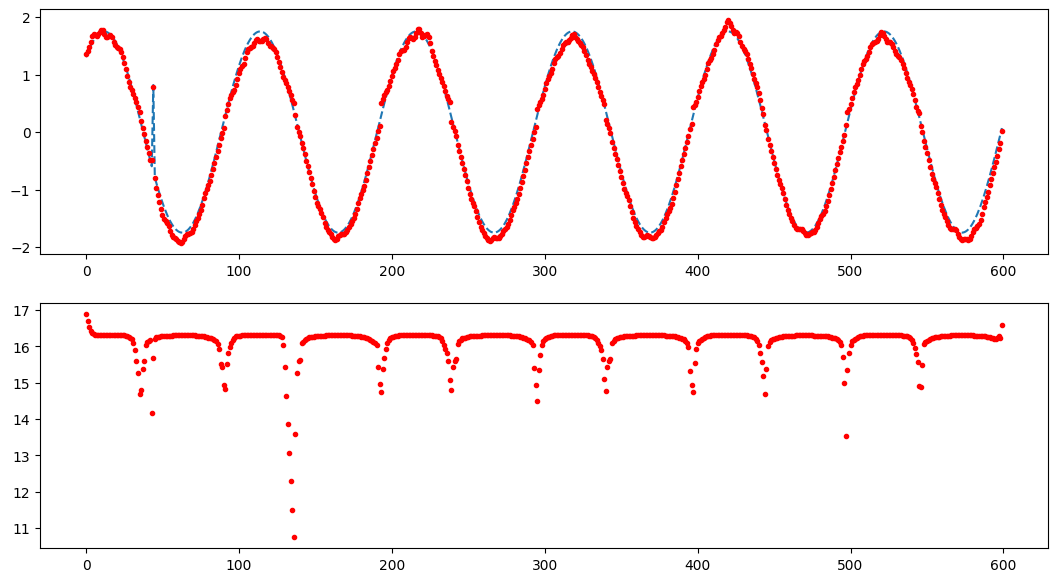

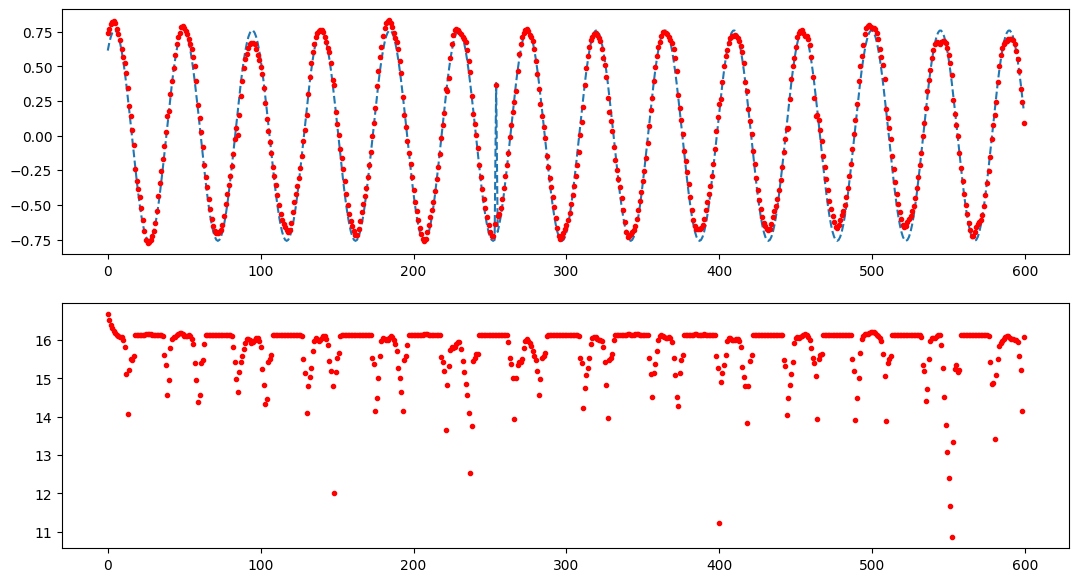

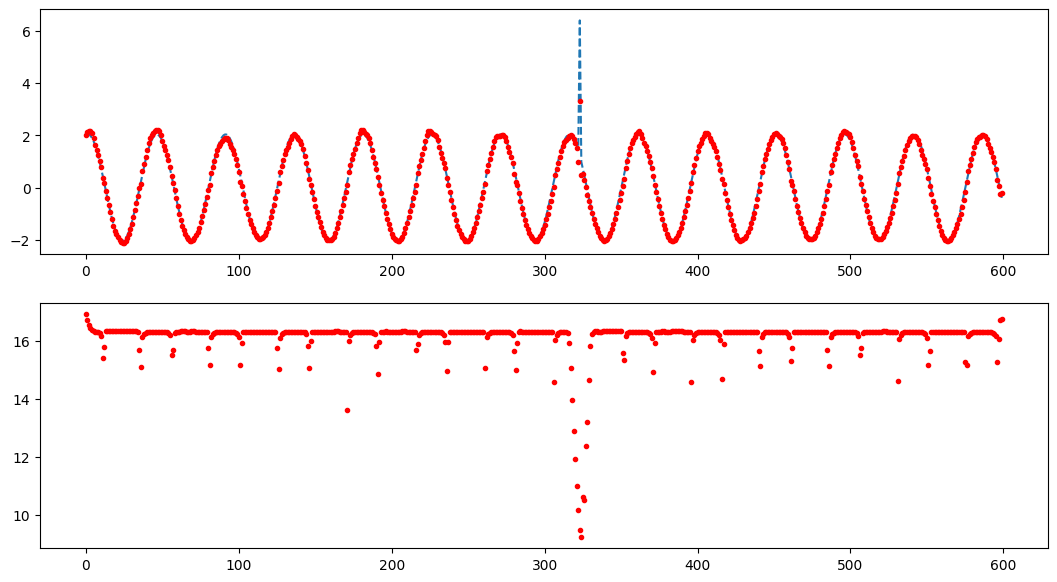

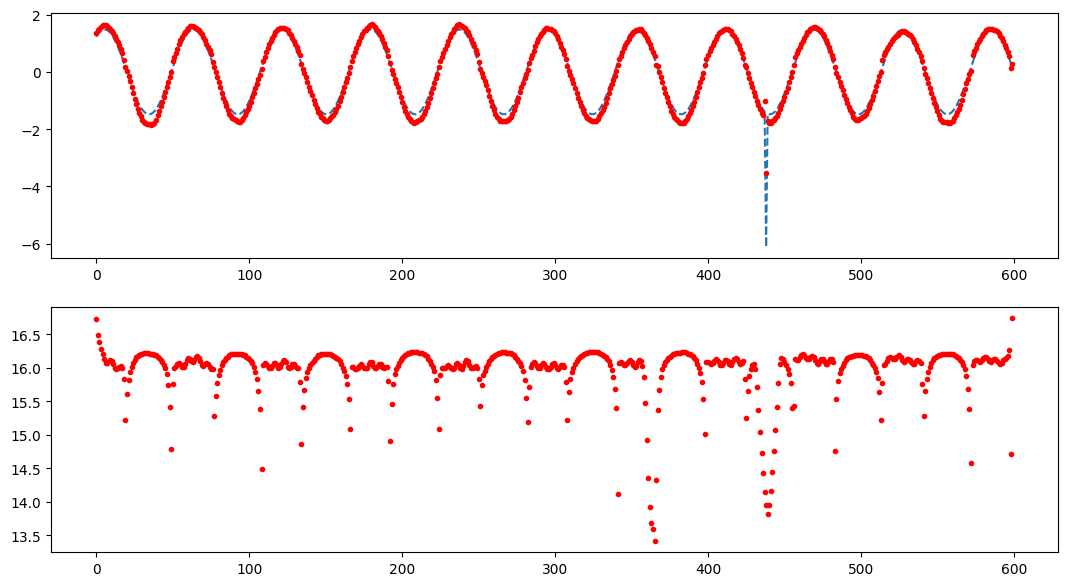

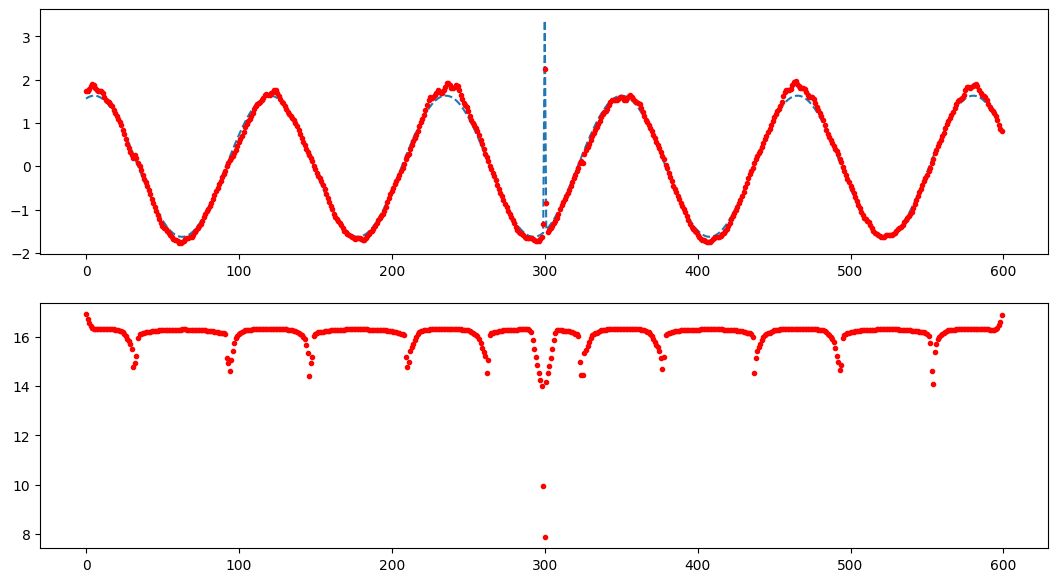

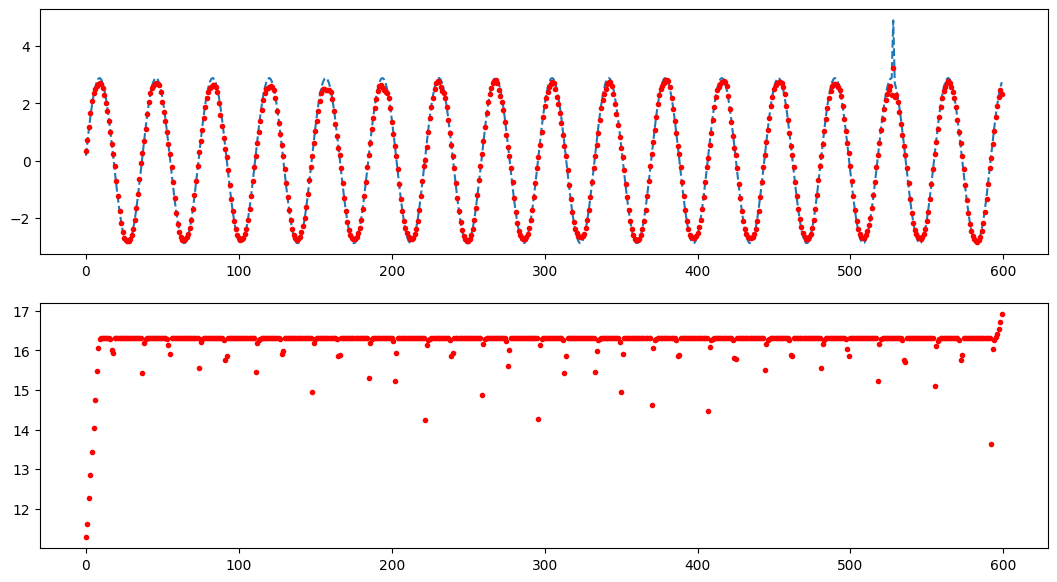

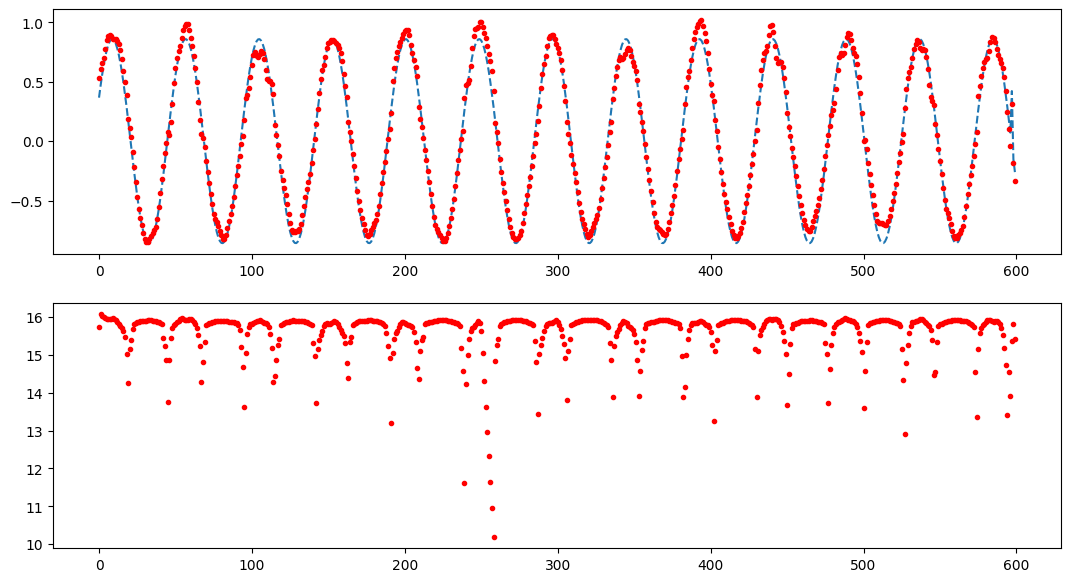

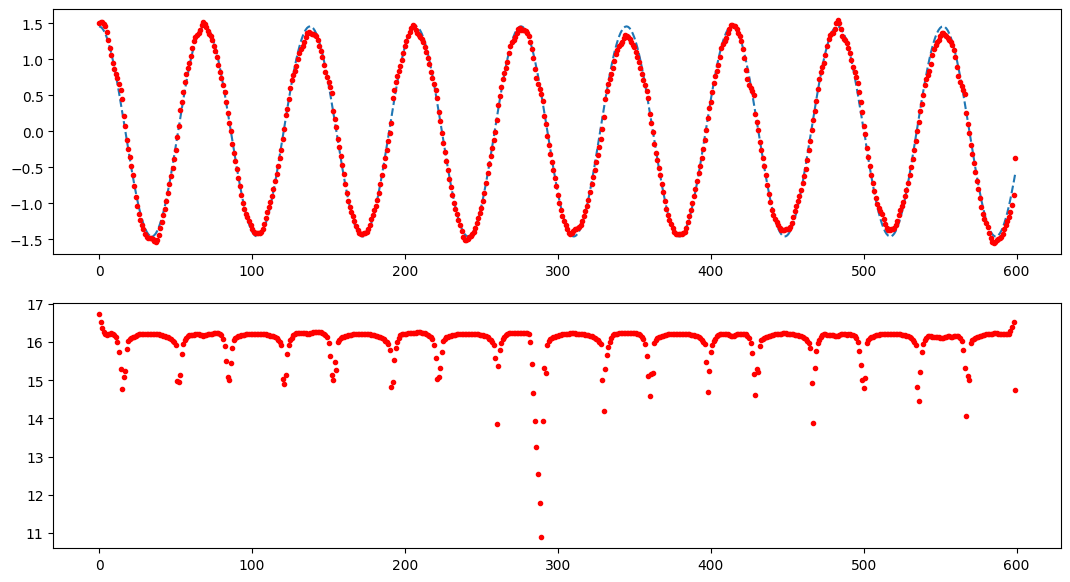

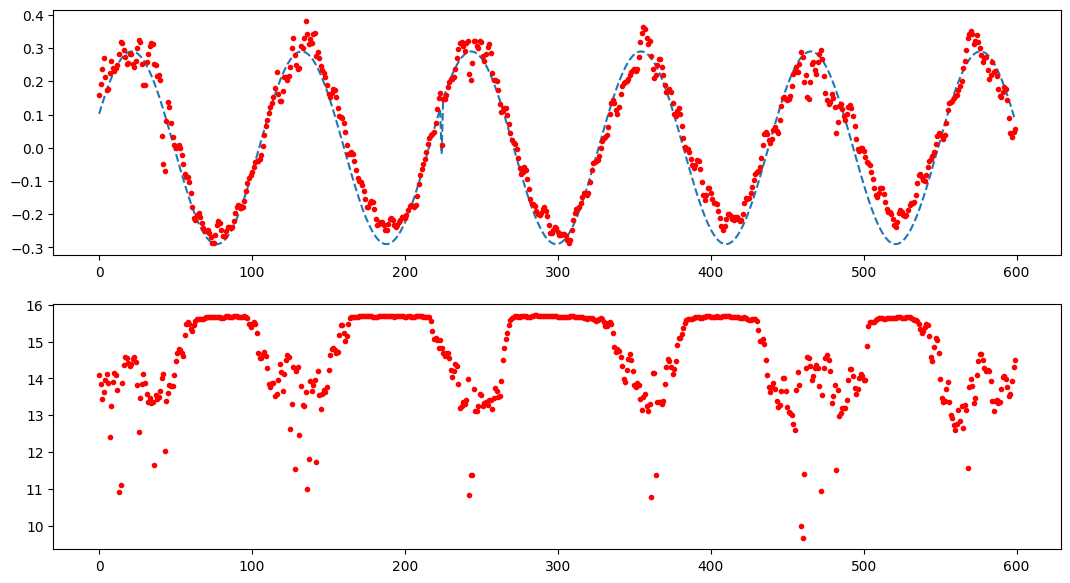

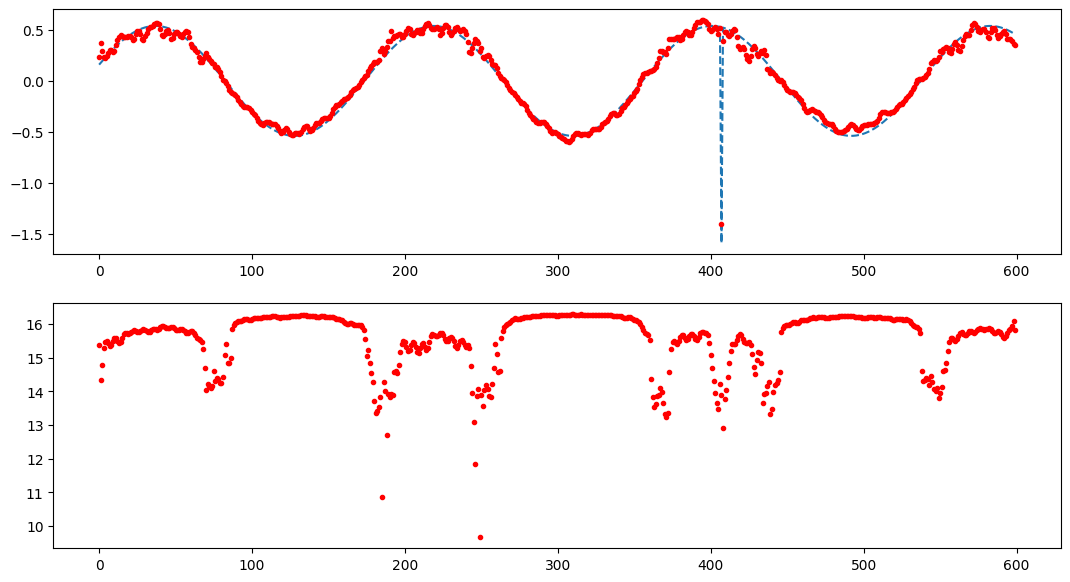

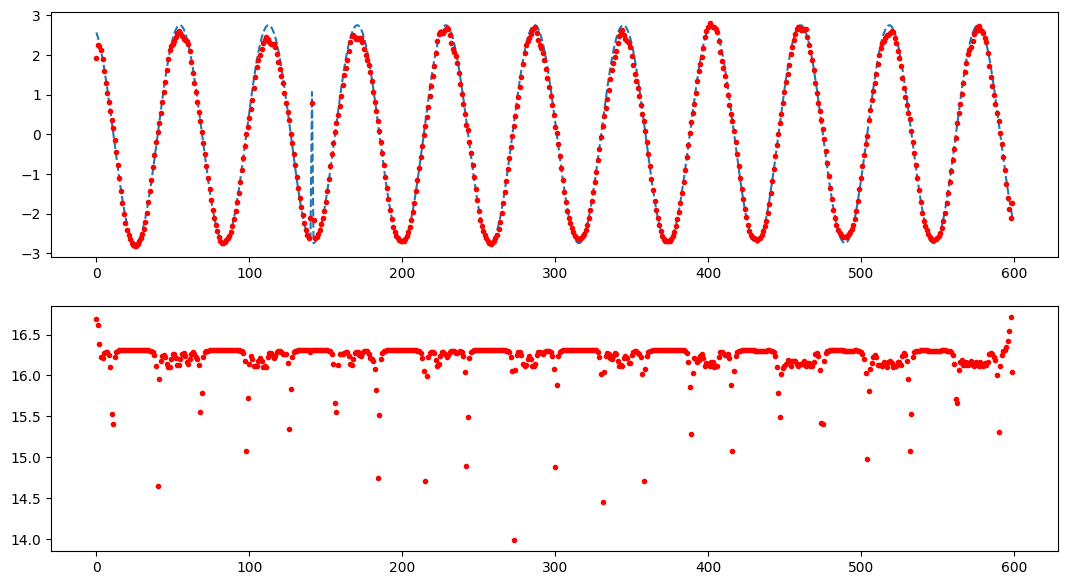

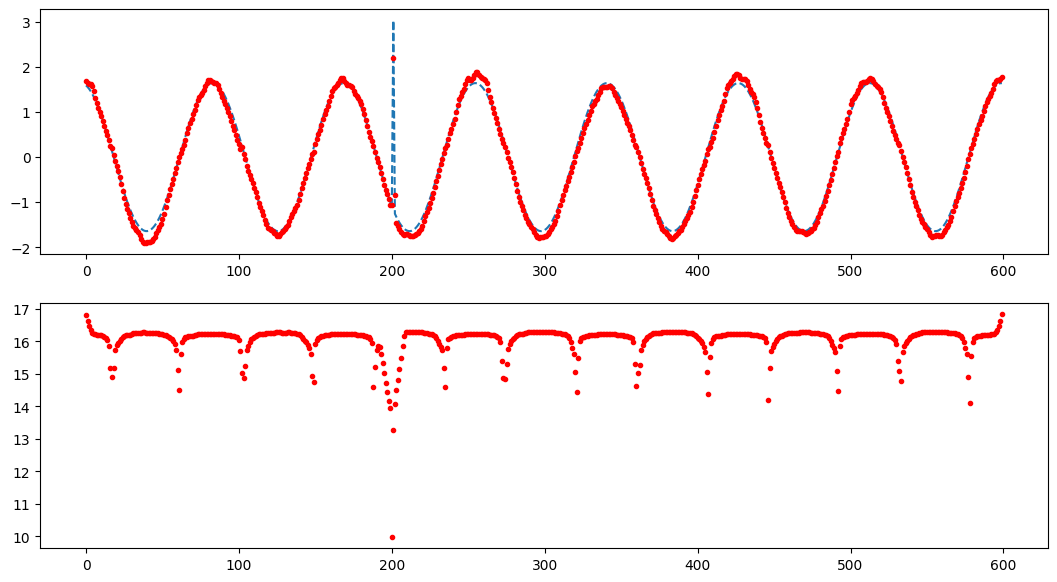

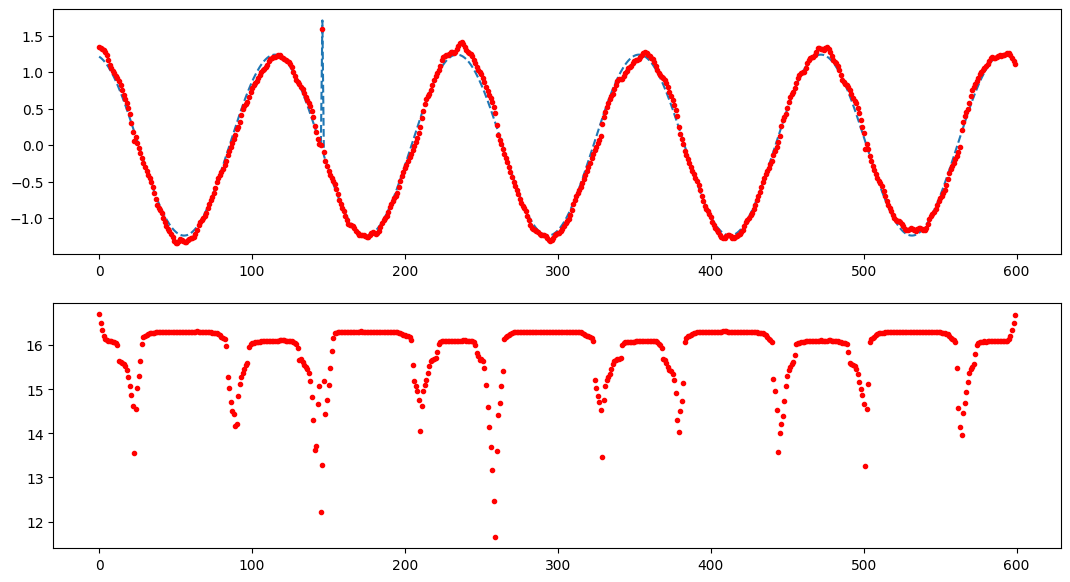

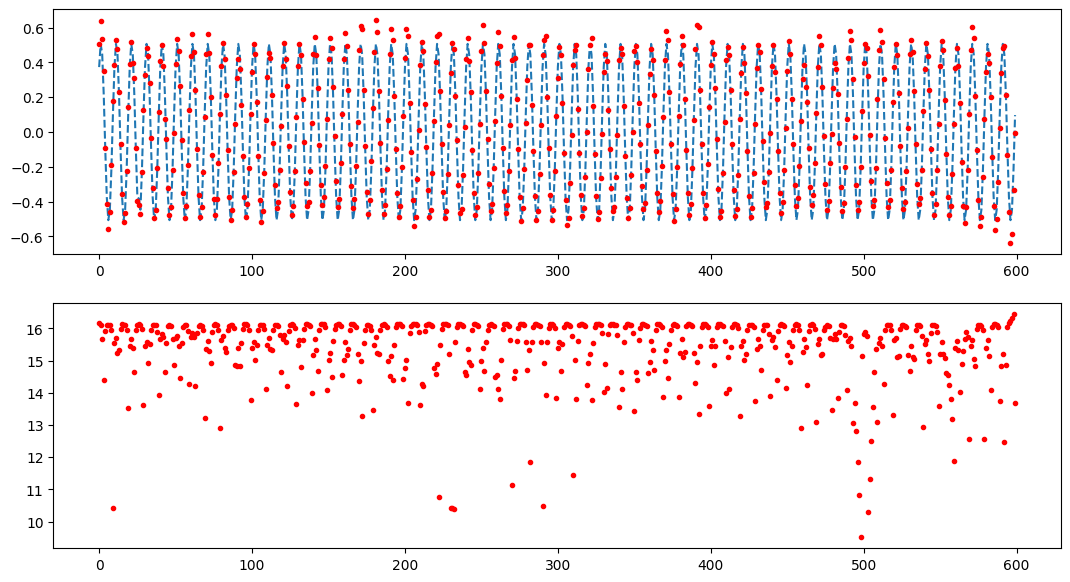

In [21]:
for n in range(19):
    plt.figure(figsize=(13,7))
    plt.subplot(2,1,1)
    plt.plot(b[n],"--")
    plt.plot(z[n],".r")
    plt.subplot(2,1,2)
    plt.plot(ass[n],".r")

In [ ]:
n=23

plt.plot(z[n])
plt.plot(b[n],"--")
plt.figure(figsize=(12,12))
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.imshow(series_aux[n][i])
    plt.subplot(2,2,i+3)
    plt.imshow(prior_aux[n][i])

Vale, esta prueba con una anomalía global a funcionado, ahora vamos a probar con algo más sutil, como un ligero valle, una anomalía contextual.

## Anomalias contextuales 



In [37]:
def add_context_anom(x):
    x=x.to(float)
    #añade en una disposiciónaleatoria, un pico del orden de las obervaciones
    points_involved=np.random.randint(3,15)
    init_index=np.random.randint(0,x.size()[0]-points_involved)
    index=torch.from_numpy(np.arange(init_index,init_index+points_involved))
    x[index]= x[init_index].repeat(points_involved)
    return x
    

In [40]:
a=sinne(130)

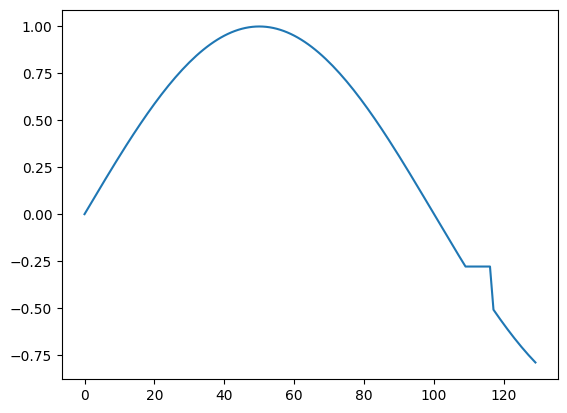

In [41]:
b=add_context_anom(a)
plt.plot(b.cpu().detach().numpy())

## Primer entrenamiento, segunda parte
Ahora en lugar de la reconstrucción de la misma señal, va a ser la reconstruccion de la señal flipeada. 


In [4]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

In [5]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)


class DataFlip(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,lenght,num_samples,amp_random=True,freq_random=True,phase_random=True,sf=0.1):
        super().__init__()
        self.amp_random=amp_random
        self.freq_random=freq_random
        self.phase_random=phase_random
        self.num_samples=num_samples
        self.sf=0.1
        self.lenght=lenght

    def __len__(self):

        return self.num_samples


    def __getitem__(self, index):
        amp=float(np.random.randint(1,300,1)*0.01)
        phase=np.random.randint(0,100,1)*0.02
        f=np.random.randint(1,200,1)*0.01
        y=sinne(lenght=self.lenght,amp=amp,sf=0.1,f=f,phase=phase)
        y=y.unsqueeze(-1)
        return y, y.flip(0)


In [6]:
win_size=600
dataflip=DataFlip(win_size,4000)

dataloader=DataLoader(dataflip,batch_size=32,shuffle=True)

In [7]:
modelo=AnomalyTransformer.AnomalyTransformer(win_size, 1, 1, d_model=32, n_heads=2, e_layers=2, d_ff=32,
                          dropout=0.0, activation='gelu', output_attention=True)
modelo.cuda()


AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=2, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bi

In [8]:
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)
modelo.train()
lambda_=0

# Entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i, (inputs,labels) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        labels=labels.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)
        prior=[j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600) for j in prior]
        loss_min = min_loss(outputs,prior,series, labels,lambda_)
        loss_max = max_loss(outputs,prior,series, labels,lambda_)

        # Backward y optimización
        loss_min.backward(retain_graph=True)
        loss_max.backward()
        #clip_gradients(modelo, max_norm=1)
        optimizer.step()
        optimizer.zero_grad()
        del inputs 
        torch.cuda.empty_cache()
        gc.collect()

        #warmup_and_decay_learning_rate(optimizer, epoch, 1e-2,15 , num_epochs)
        # Printear resultados
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss_min: {loss_min.item():.4f}, Loss_max: {loss_max.item():.4f}")

print("Entrenamiento finalizado")

Epoch: 0
tensor(1.3865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.5551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3865, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.5551, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [1/125], Loss_min: 1.3865, Loss_max: 1.3865
tensor(2.0922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.4608, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.0922, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.4608, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [2/125], Loss_min: 2.0922, Loss_max: 2.0922
tensor(1.5530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.2763, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.2763, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [3/125], Loss_min: 1.5530, Loss_max: 1.5530
tensor(1.7077, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.2217, device='cuda:0', grad_fn=<MeanBackward0>)
tens

In [9]:
#modelo.cuda()
a_x,a_label=next(iter(dataloader))
a_x_cuda=a_x.float().to("cuda:0")
modelo.eval()
output,series_aux,prior_aux,_=modelo(a_x_cuda)


output=output.squeeze().cpu().detach().numpy()
series_aux=series_aux[0].squeeze().cpu().detach().numpy()
prior_aux=prior_aux[0].squeeze().cpu().detach().numpy()


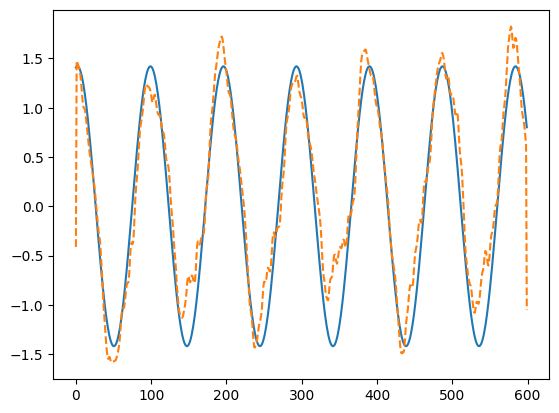

In [18]:
plt.plot(a_label[31])
plt.plot(output[31],"--")

## Primer entrenamiento tercera parte (con lr schedule, pero sin clipping)

Es exactamente lo mismo que antes, con el vector invertido, pero con lr schedule.

In [1]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

In [22]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)


class Data(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,lenght,num_samples,amp_random=True,freq_random=True,phase_random=True,sf=0.1):
        super().__init__()
        self.amp_random=amp_random
        self.freq_random=freq_random
        self.phase_random=phase_random
        self.num_samples=num_samples
        self.sf=0.1
        self.lenght=lenght

    def __len__(self):

        return self.num_samples


    def __getitem__(self, index):
        amp=float(np.random.randint(1,300,1)*0.01)
        phase=np.random.randint(0,100,1)*0.02
        f=np.random.randint(1,200,1)*0.01
        y=sinne(lenght=self.lenght,amp=amp,sf=0.1,f=f,phase=phase)
        y=y.unsqueeze(-1)
        return y


def warmup_and_decay_learning_rate(optimizer, epoch, init_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        lr = init_lr * (epoch / warmup_epochs)
        print('Warmup: Updating learning rate to {}'.format(lr))
    else:
        decay_epochs = total_epochs - warmup_epochs
        decay_rate = 1e-7+(epoch - warmup_epochs) / decay_epochs
        lr = init_lr * (1 - decay_rate)
        print('Decay: Updating learning rate to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def clip_gradients(model, max_norm, norm_type=2):
    """
    Clip gradients of the model parameters.

    Args:
        model (torch.nn.Module): The neural network model.
        max_norm (float): The maximum allowed norm for the gradients.
        norm_type (float): The type of the norm calculation (default: 2 for L2 norm).
    """
    # Recupera todos los gradientes de los parámetros del modelo
    gradients = [param.grad for param in model.parameters() if param.grad is not None]

    # Calcula la norma total de los gradientes
    total_norm = torch.norm(torch.stack([torch.norm(grad, norm_type) for grad in gradients]), norm_type)

    # Calcula el factor de escalado para recortar los gradientes
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        # Aplica el factor de escalado a los gradientes
        for grad in gradients:
            grad.mul_(clip_coef)




# def layer_association_discrepancy( Pl, Sl):
#     #Pl y Sl viene con dimension B,Head,Height,Width
#     B,Head,Height,_ = Pl.shape
#     result=torch.zeros(B,Head,Height)
#     for batch_size in range(B):
#         for head_size in range(Head):
#             rowwise_kl = lambda row: (F.kl_div(Pl[batch_size,head_size,row, :], Sl[batch_size,head_size,row, :]) + F.kl_div(Sl[batch_size,head_size,row, :], Pl[batch_size,head_size,row, :]))
#             ad_vector = torch.concat([rowwise_kl(row).unsqueeze(0) for row in range(Height)])
#             result[batch_size,head_size,:]=ad_vector
#     return result

def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)



# def layer_association_discrepancy(Pl, Sl):
#     # Pl y Sl vienen con dimension B, Head, Height, Width
#     B, Head, Height, _ = Pl.shape

#     # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
#     kl1 = F.kl_div(Pl, Sl, reduction='none').mean(dim=-1)
#     kl2 = F.kl_div(Sl, Pl, reduction='none').mean(dim=-1)

#     # Sumar los KL Divergence calculados
#     ad_vector = kl1 + kl2

#     return ad_vector

def layer_association_discrepancy(Pl, Sl):
    # Pl y Sl vienen con dimension B, Head, Height, Width
    B, Head, Height, _ = Pl.shape

    # Calcular el KL Divergence entre Pl y Sl a lo largo del último eje (Width)
    kl1 = my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
    kl2 = my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))

    # Sumar los KL Divergence calculados
    ad_vector = kl1 + kl2

    return ad_vector



def association_discrepancy( P_list, S_list):

    return torch.stack([layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])

# (1 / len(P_list)) * sum(
#         [
#             torch.mean(layer_association_discrepancy(P, S),axis=0)#hacemos la media sobre todas las cabezas
#             for P, S in zip(P_list, S_list)
#         ]
#     )

def loss_function( x_hat, P_list, S_list, lambda_, x):
    frob_norm = ((x_hat - x)**2).mean()   #usamo MSE  #torch.linalg.matrix_norm(x_hat - x, ord="fro").mean() #norm L2 
    diss_norm=torch.mean(association_discrepancy(P_list, S_list))#torch.linalg.norm(, ord=1) # le añado esto para que se normaliza acros muestras 
    print(frob_norm,diss_norm)
    return frob_norm - (lambda_* diss_norm) #hacemos la suma de todos los valores absolutos y dividimos todo por el batchsize
    

def min_loss(output,P_layers,S_layers, x,lambda_):
    P_list = P_layers
    S_list = [S.detach() for S in S_layers]
    lambda_ = -lambda_
    return loss_function(output, P_list, S_list, lambda_, x)

def max_loss(output,P_layers,S_layers,x,lambda_):
    P_list = [P.detach() for P in P_layers]
    S_list = S_layers
    lambda_ = lambda_
    return loss_function(output, P_list, S_list, lambda_, x)


In [23]:
win_size=600
data=Data(win_size,4000)

dataloader=DataLoader(data,batch_size=32,shuffle=True)

In [34]:
modelo=AnomalyTransformer.AnomalyTransformer(win_size, 1, 1, d_model=32, n_heads=2, e_layers=2, d_ff=32,
                          dropout=0.0, activation='gelu', output_attention=True)
modelo.cuda()


AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=2, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bi

In [35]:
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)
modelo.train()
lambda_=1

# Entrenamiento
num_epochs = 15
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i, (inputs) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)
        prior=[j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 600) for j in prior]
        loss_min = min_loss(outputs,prior,series, inputs,lambda_)
        loss_max = max_loss(outputs,prior,series, inputs,lambda_)

        # Backward y optimización
        loss_min.backward(retain_graph=True)
        loss_max.backward()
        #clip_gradients(modelo, max_norm=1)
        optimizer.step()
        optimizer.zero_grad()
        del inputs 
        torch.cuda.empty_cache()
        gc.collect()

        warmup_and_decay_learning_rate(optimizer, epoch, 1e-2,6 , num_epochs)
        # Printear resultados
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss_min: {loss_min.item():.4f}, Loss_max: {loss_max.item():.4f}")

print("Entrenamiento finalizado")

Epoch: 0
tensor(1.6430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.8944, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.6430, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.8944, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/15], Step [1/125], Loss_min: 10.5373, Loss_max: -7.2514
tensor(1.9131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.1292, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9131, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.1292, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/15], Step [2/125], Loss_min: 11.0423, Loss_max: -7.2161
tensor(1.3403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0161, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.0161, device='cuda:0', grad_fn=<MeanBackward0>)
Warmup: Updating learning rate to 0.0
Epoch [1/15], Step [3/125], Loss_min: 10.3564, Loss_max: -7.675

In [38]:
#modelo.cuda()
a_x=next(iter(dataloader))
a_x_cuda=a_x.float().to("cuda:0")
modelo.eval()
output,series_aux,prior_aux,_=modelo(a_x_cuda)


output=output.squeeze().cpu().detach().numpy()
series_aux=series_aux[0].squeeze().cpu().detach().numpy()
prior_aux=prior_aux[0].squeeze().cpu().detach().numpy()


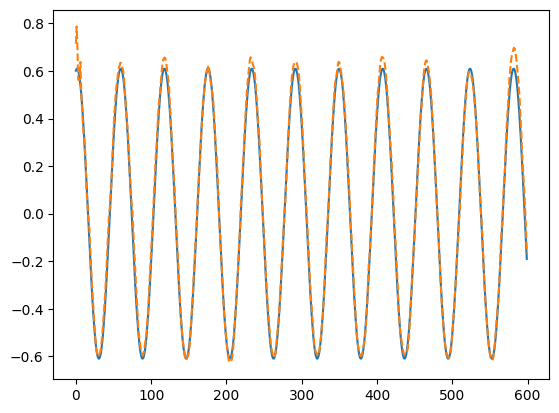

In [55]:
n=11
plt.plot(a_x[n])
plt.plot(output[n],"--")